In [93]:
# The Distribution Simulater is design to create pattern for culsttering
# analysis. 
# By Chien-cheng Shih (Mike)
# From Washington University Center for Cellular Imaging

# PoissonPP and ThomasPP are adpated from Connor Johnson's blog post
# (http://http://connor-johnson.com/2014/02/25/spatial-point-processes/)
# The ability for seed control is added for generating random numbers.  

import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('AriaRen','AtiibfXGar8FRpQvhnzD')

In [2]:
def PoissonPP(rt, N = None, ndimension = 2, rangelim = None, seed = None, seedmodifier = 1):
    '''
    rt = rate of Poisson distribution
    N = force to over write N (default = None)
    ndimension: the number of dimension (default = 2)
    rangelim: the limt for each dimension (default = None)
    seed = seed variable for random_state in .rvs arguments (default = None)
    seedmodifier = allow the seed value changes when iterating through dimensions (default = 1)
    PoissonPP determines the number of events 'N' for a rectangular region,
    given the rate 'rt', the dimensions. Returns a <N x ndimension > NumPy array. 
    Rangelim (NumPy array) defines the limit for each dimension. 
    
    Format needs to be: 
    [[x1_min, x1_max], 
     [x2_min, x2_max],
     [x3_min, x3_max], ...]]   
    
    Randomization can be controled by seed and seedmodifier. 
    
    Add-on:
    For rangelim, if the size of dimension is smaller than 1, which presumably return N as 0,  
    directly input N is allowed. 
    '''
    # check the value of rt
    if not (0 <= rt <= 1): 
        raise ValueError('error: var "rt" is a value between 0 and 1')
    
    # create a default ranage for each dimension if no limits are assigned.
    if rangelim is None:
        rangelim = np.zeros([ndimension, 2])
        rangelim[:, 1] = 20

    # return an error message when the input limits are inconsistent with the given n dimension
    if rangelim.shape[0] != ndimension:
        print('ndimension: {}'.format(ndimension))
        print('reangelim:')
        print(rangelim)
        raise ValueError('error: the dimension of array "rangelim" is not consistent with the var "ndimension"')
        return
    
    # create the size of range
    rangesize = rangelim[:,1] - rangelim[:,0]
    # create total space
    rangeprod = np.prod(rangesize, axis = 0)
    # calculate N based on the given dimension
    if N == None:
        if seed == None: 
            N = scipy.stats.poisson(rt*rangeprod).rvs()
        else:
            N = scipy.stats.poisson(rt*rangeprod).rvs(random_state=seed)
    
    # <array pre-allocation>
    # create zero matrix
    array = np.zeros([N, ndimension])
    # print(array.shape)
    seedtmp = seed
    # create random value for each dimension
    for i in range(ndimension):
        if seedtmp == None:
            tmp_rndvar = scipy.stats.uniform.rvs(loc = 0, scale = rangesize[i], size = N)
            
        else:
            tmp_rndvar = scipy.stats.uniform.rvs(loc = 0, scale = rangesize[i], size = N, random_state = seedtmp)
            seedtmp += seedmodifier

        tmp_rndvar_offset = rangelim[i][0] + tmp_rndvar
        
        # inject the array into pre-allocated array
        array[:, i] = tmp_rndvar_offset

    return(array)

In [3]:
def ThomasPP(rt, sigma, mu, N = None, ndimension = 2, rangelim = None, seed = None, seedmodifier = 1):
    '''
    rt = rate of Poisson distribution
    sigma = the standard deviation of Gaussian distribution surrounding parent points
    mu = generate the count for each Gaussian distribution following Poisson distribution
    N = force to over write N (default = None)
    ndimension: the number of dimension (default = 2)
    rangelim: the limt for each dimension (default = None)
    seed = seed variable for random_state in .rvs arguments (default = None)
    seedmodifier = allow the seed value changes when iterating through dimensions (default = 1)
    
    THOMASPP generates multiple Gaussian distribution surrounding given parents points, 
    which are created by PoissonPP(). The sample size of Gaussian distribution is determined by 
    Poisson distribution 'mu', where the variance is determined by 'Sigma'.
  
    '''

    # Create a set of parent points form a Poisson
    array_points_parents = PoissonPP(rt, N, ndimension, rangelim, seed, seedmodifier)
    
    # M is the number of parents
    M = array_points_parents.shape[0]
    # Create array for random count
    count_list = []
    
    # Create counts for each parent point
    seedtmp = seed
    for i in range(M):
        # print(seedtmp)
        if seedtmp == None:
            child_count = scipy.stats.poisson(mu).rvs()
        else: 
            child_count = scipy.stats.poisson(mu).rvs(random_state=seedtmp)
            seedtmp += seedmodifier
        count_list.append(child_count)
    # print(count_list)
    # return total number for the childern points
    total_count = sum(count_list)
    # create the index for start and end
    childern_idx_start = np.concatenate([np.array([0]), np.cumsum(count_list)[0: -1]])
    # print(childern_idx_start)
    childern_ide_end = np.cumsum(count_list)
    # print(childern_ide_end)
    
    # <array pre-allocation>
    array_points_childern = np.zeros([total_count, ndimension])
    
    seedtmp = seed    
    for i in range(M):
        # return the count for the given parent point
        childern_count = count_list[i]
        # return the coordinate for the given parent point
        parent = array_points_parents[i]
        # <array pre-allocation>
        array_temp = np.zeros([childern_count, ndimension])      
        for j in range(ndimension):
            parent_value = parent[j]
            if seedtmp == None:
                pdf = scipy.stats.norm(loc = parent_value, scale = sigma)
                array_temp[:, j] = list(pdf.rvs(childern_count))
            else:
                pdf = scipy.stats.norm(loc = parent_value, scale = sigma)  
                array_temp[:, j] = list(pdf.rvs(childern_count, random_state = seedtmp))
                seedtmp += seedmodifier
        # print(array_temp)
        array_points_childern[childern_idx_start[i]:childern_ide_end[i], :] = array_temp
    
    return(array_points_childern, array_points_parents)

In [94]:
def ThomasPP_Multi(rt, sigma, mu):
    if len(sigma) != len(mu):
        raise ValueError('error: the scale of sigma list for different group should be the same of the scale of mu list')
        return
    if len(rt) != len(mu):
        raise ValueError('error: the scale of rate list for different group should be the same of the scale of mu list')
        return
    Num_Group = len(sigma)
    results = []
    #results = np.empty()
    #results = ThomasPP(rt[0], sigma[0], mu[0], N = None, ndimension = 3, rangelim = None, seed = None, seedmodifier = 1)
    for i in range(Num_Group):
        M = ThomasPP(rt[i], sigma[i], mu[i], N = None, ndimension = 2, rangelim = None, seed = None, seedmodifier = 1)
        for j in range(2):
            for m in M[j]:
                n = np.insert(m,0,i+1)
                results.append(n)
        #M_group = np.concatenate([np.array([[1]]), M])
        #results = np.stack((results, M))
        #N = "ThomasPP_Multigroup_"+str(i+1)
        # print(N, M)
        #np.concatenate([results, M], axis = 0)
        
        
    
    return results
      

In [214]:
a1 = ThomasPP_Multi([0.5, 0.5, 0.5], [0.2, 0.5, 0.3], [20,30,40])

In [215]:
import pandas as pd
a1 = pd.DataFrame(a1)
#a1.to_csv("newdata2.csv",index = False)

In [216]:
group1 = a1.loc[a1[0]==1, :]
group2 = a1.loc[a1[0]==2, :]
group3 = a1.loc[a1[0]==3, :]

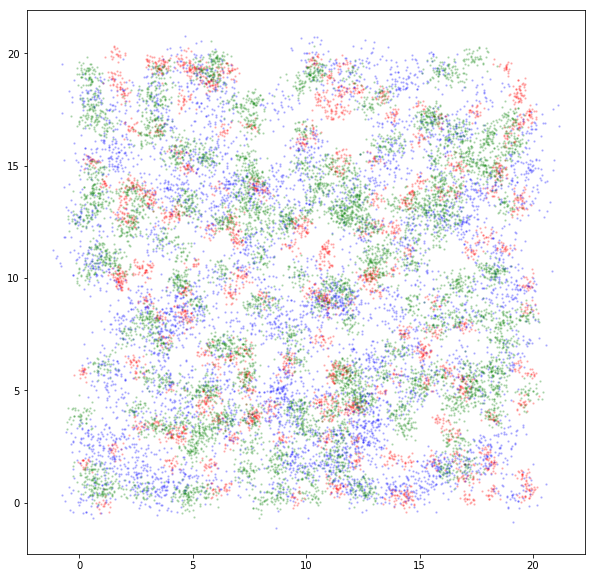

In [217]:
plt.figure(figsize = [10, 10])
plt.scatter(x = group1[1], y = group1[2], data=group1, alpha = 0.2, c='red', s = 2)
plt.scatter(x = group2[1], y = group2[2], data=group2, alpha = 0.2, c='blue',s = 2)
plt.scatter(x = group3[1], y = group3[2], data=group3, alpha = 0.2, c='green',s = 2)

In [178]:
b = ThomasPP(0.5, 0.2, 30, N = None, ndimension = 2, rangelim = None, seed = None, seedmodifier = 1)
b_childs = b[0]
print(b_childs)

[[ 9.15131643 10.97108233]
 [ 8.93624896 10.78128043]
 [ 8.98715379 10.87279437]
 ...
 [15.63288299  8.20885308]
 [15.46688973  7.61442293]
 [15.65940801  8.16565528]]


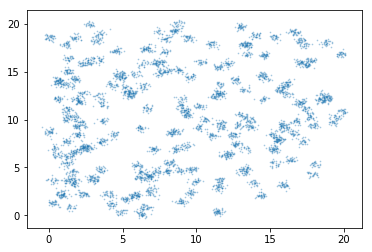

In [181]:
plt.figure()
plt.scatter(b_childs[:, 0], b_childs[:, 1], s = 0.6, alpha = 0.3)
plt.show()

In [ ]:
result = []
for i in range(2):
    for m in b[i]:
        result.append(m)
plot2d = pd.DataFrame(result)
plot2d
plt.scatter(x = plot2d[0], y = plot2d[1], data=plot2d, alpha = 0.3, c='red')

In [ ]:
result = []
for i in range(2):
    for m in b[i]:
        result.append(m)
plot2d = pd.DataFrame(result)
plot2d
plt.scatter(x = plot2d[0], y = plot2d[1], data=plot2d, alpha = 0.3, c='red')

In [126]:
trace0 = go.Scatter(
    x = group1[1],
    y = group1[2],
    name = 'group1',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'rgba(152, 0, 0, .8)',
        line = dict(
            width = 2,
            color = 'rgb(0, 0, 0)'
        )
    )
)
trace1 = go.Scatter(
    x = group2[1],
    y = group2[2],
    name = 'group2',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'rgb(255,255,191)',
        line = dict(
            width = 2,
            color = 'rgb(0, 0, 0)'
        )
    )
)
trace2 = go.Scatter(
    x = group3[1],
    y = group3[2],
    name = 'group3',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'rgb(145,191,219)',
        line = dict(
            width = 2,
            color = 'rgb(0, 0, 0)'
        )
    )
)
data = [trace0, trace1, trace2]
layout = dict(title = '2-Dimension Multigroup Plot',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='2-Dimension Multigroup Plot')

In [113]:
import colorlover as cl
from IPython.display import HTML
import math